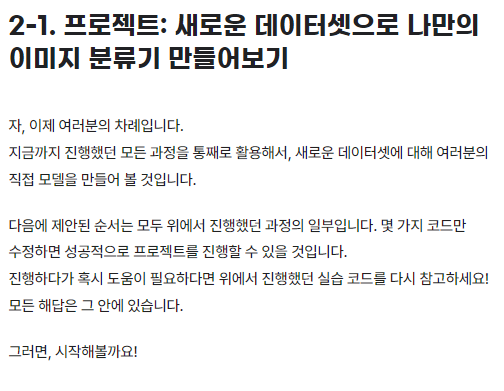

In [3]:
import warnings
warnings.filterwarnings("ignore")#경고 무시

In [4]:
import tensorflow as tf #라이브러리와 데이터셋 불러오기
import tensorflow_datasets as tfds


In [5]:
!mkdir -p ~/aiffel/flowers/flowerimages
!ln -s ~/data/* ~/aiffel/flowers/

ln: failed to create symbolic link '/aiffel/aiffel/flowers/cats_vs_dogs': File exists


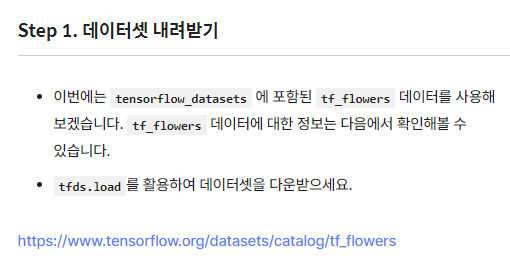

In [6]:
#tf.f;owers 데이터셋 다운
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/flowers/',
    download=True,
    with_info=True,
    as_supervised=True,
)


In [7]:
#데이터 형상확인
print(raw_train)
print(raw_validation)
print(raw_test)
len(raw_train)
len(raw_validation)
len(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


367

In [9]:
#데이터 시각화위한 라이브러리 다운및 설정
import matplotlib.pyplot as plt
%matplotlib inline #주피터 노트북 내에서 matplotlib을 사용하여 그래프를 그릴 때, 그래프를 노트북 셀 안에 바로 보여주도록 설정
%config InlineBackend.figure_format = 'retina'#그래프의 화질을 'retina' 디스플레이에 최적화된 고해상도로 설정



UsageError: unrecognized arguments: #주피터 노트북 내에서 matplotlib을 사용하여 그래프를 그릴 때, 그래프를 노트북 셀 안에 바로 보여주도록 설정


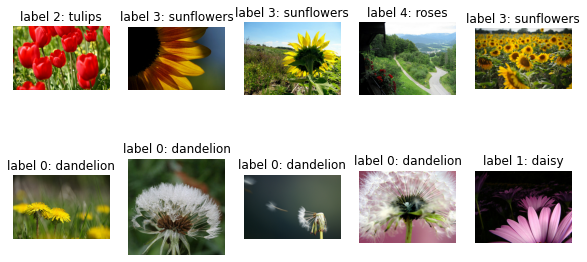

In [10]:
#이미지 데이터셋 확인
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

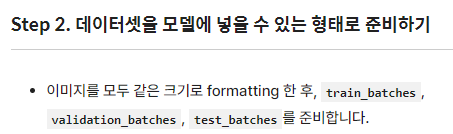

In [11]:
#이미지 데이터셋의 크기가 각각 다르기때문에 모델에 input시 크기를 맞춰줘야함으로 이미지resizing
IMG_SIZE = 160 # 리사이징할 이미지의 크기
#리사이징시킬 함수구현
def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/255)  # 픽셀값의 scale 수정(정규화)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label



In [12]:
#format_example함수를 통해 쉽게 데이터셋의 형상 변경
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)
#IMG_SIZE를 160으로 지정해 줌으로써, 모든 이미지의 크기를 (160, 160, 3)으로 통일시켰습니다.

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


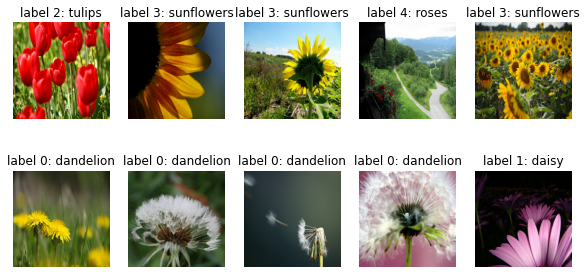

In [13]:
#시각화코드
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = image #image
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')
#다시 이미지를 시각적으로 확인해 다시 확인해 보니 모든 이미지의 크기가 균일해진 것을 확인할 수 있습니다

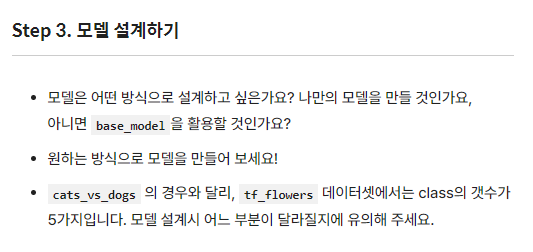

In [14]:
#배치사이즈 설정
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
#데이터 형상확인
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape


(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [15]:
#이미지 분류기때문에 잘 학습되있는 모델을 가져오기 (vgg16)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [16]:
#Global Average Pooling 계층을 만드는 코드를 확인해 보겠습니다.
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [17]:
# dense layer구현
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.

dense_layer = tf.keras.layers.Dense(units=512, activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2')
dense_layer = tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2')
dense_layer = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')#,kernel_regularizer='l2')
# unit은 우리가 분류하고 싶은 class가5개이다..
# 다중 클래스 분류기때문에 활성화 함수는 Softmax를 사용합니다.
prediction_layer =tf.keras.layers.Dense(units=5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)
#최종데이터의 형상이 5개의 노드로 구성된것을 알수있다.

(32, 5)


In [18]:
#모델 설계
base_model.trainable = False
import tensorflow as tf
from tensorflow. keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
#최종모델
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
#모델구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 14,780,997
Trainable params: 66,309
Non-trainable params: 14,714,688
_________________________________________________________________


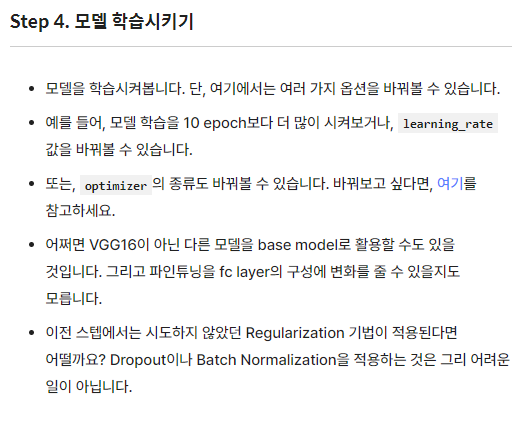

In [19]:
#모델컴파일
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,#레이블이 정수형이기때문에 
              metrics=['accuracy'])

In [20]:
# validation_steps=20
# loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

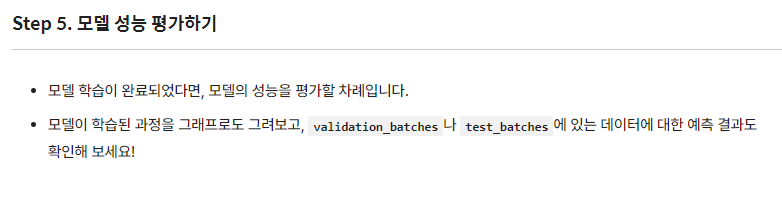

In [21]:
EPOCHS = 20   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 18s 136ms/step - loss: 1.1666 - accuracy: 0.5698 - val_loss: 0.8864 - val_accuracy: 0.6921
Epoch 2/20
92/92 [==============================] - 8s 77ms/step - loss: 0.7506 - accuracy: 0.7490 - val_loss: 0.7178 - val_accuracy: 0.7357
Epoch 3/20
92/92 [==============================] - 7s 78ms/step - loss: 0.6485 - accuracy: 0.7800 - val_loss: 0.7512 - val_accuracy: 0.7330
Epoch 4/20
92/92 [==============================] - 8s 79ms/step - loss: 0.5928 - accuracy: 0.7922 - val_loss: 0.6369 - val_accuracy: 0.7738
Epoch 5/20
92/92 [==============================] - 8s 79ms/step - loss: 0.5389 - accuracy: 0.8178 - val_loss: 0.6331 - val_accuracy: 0.7711
Epoch 6/20
92/92 [==============================] - 8s 80ms/step - loss: 0.5105 - accuracy: 0.8260 - val_loss: 0.5933 - val_accuracy: 0.7766
Epoch 7/20
92/92 [==============================] - 8s 81ms/step - loss: 0.4791 - accuracy: 0.8351 - val_loss: 0.5693 - val_accuracy: 0.7902
Epoch 8/20


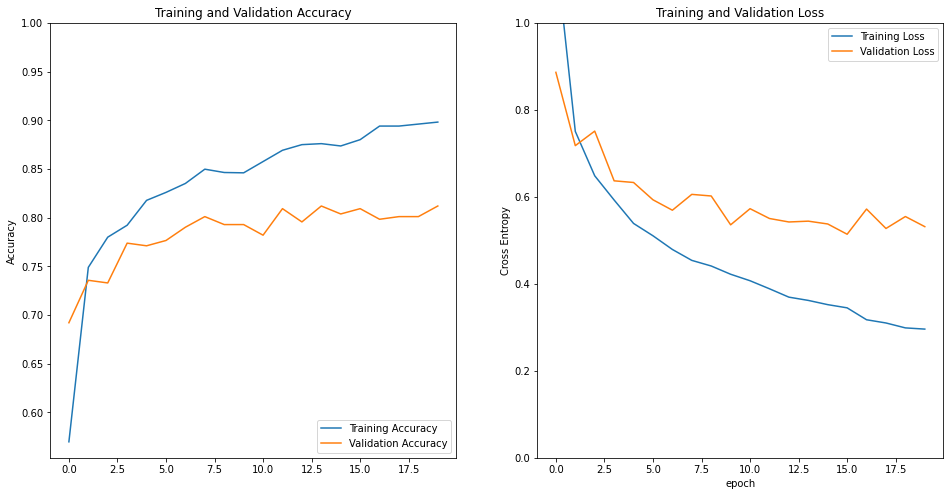

In [29]:
#학습과정 그래프로 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.42595242e-03, 3.09155639e-02, 8.08748960e-01, 4.41882126e-02,
        1.14721216e-01],
       [9.99823153e-01, 1.64985744e-04, 1.94411541e-07, 3.95674704e-07,
        1.12790412e-05],
       [3.84174615e-01, 1.69000268e-01, 1.40358582e-01, 2.63192087e-01,
        4.32744585e-02],
       [1.68099559e-05, 5.09853067e-04, 7.22451329e-01, 4.39575524e-05,
        2.76978105e-01],
       [9.20716166e-01, 7.12774172e-02, 6.52236689e-04, 1.98914684e-04,
        7.15527358e-03],
       [9.92857814e-01, 1.52465852e-03, 4.07004874e-04, 4.40791249e-03,
        8.02565599e-04],
       [4.96923588e-02, 1.50997669e-01, 6.56449795e-01, 1.37397544e-02,
        1.29120395e-01],
       [5.23761213e-01, 4.15534317e-01, 3.83513421e-03, 3.94421071e-02,
        1.74272340e-02],
       [3.24734312e-04, 2.06293364e-04, 8.68787616e-02, 8.36810708e-01,
        7.57795498e-02],
       [9.99899983e-01, 9.28574009e-05, 7.03231890e-08, 4.93567222e-06,
        2.13697581e-06],
       [9.94013369e-01, 4.8810

In [31]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 3, 4, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

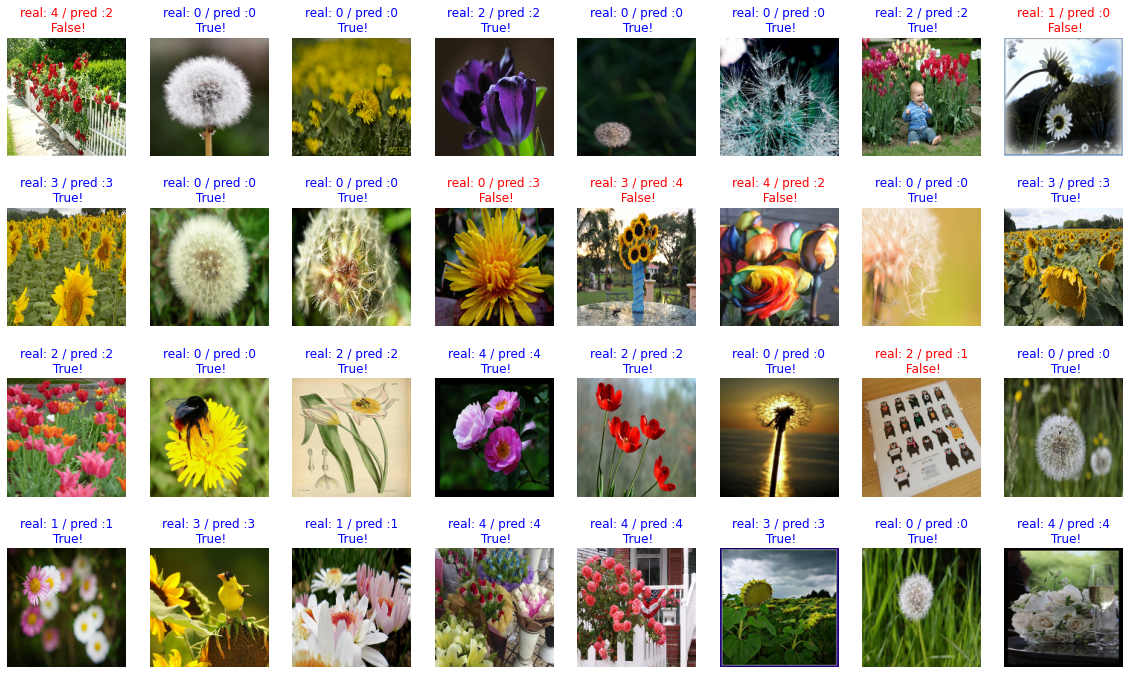

In [32]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = image
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

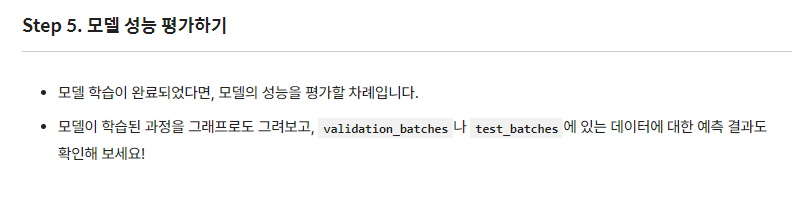

In [33]:
# 테스트 데이터로 정확도 확인
test_loss, test_accuracy = model.evaluate(test_batches)

# 평가 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100}%")

12/12 [==============================] - 1s 66ms/step - loss: 0.4458 - accuracy: 0.8529
Test Loss: 0.4457588195800781
Test Accuracy: 85.28610467910767%


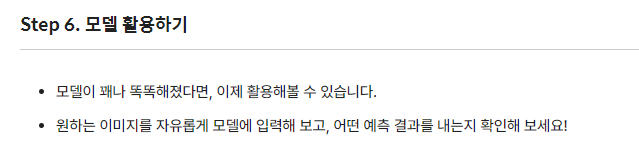

In [27]:
import os

# 현재 작업 디렉토리의 절대 경로를 얻습니다.
current_dir = os.getcwd()

# 상대 경로를 절대 경로로 변환합니다.
flower_image_path = os.path.join(current_dir, 'aiffel')
filename = "flower_test.jpg"
file_path = os.path.join(flower_image_path, filename)

# 파일이 존재하는지 확인합니다.
if os.path.exists(file_path):
    # 파일이 존재하면 이미지를 로드하고 예측을 수행합니다.
    show_and_predict_image(flower_image_path, filename)
else:
    print(f"Error: The file {file_path} does not exist.")


Error: The file /aiffel/aiffel/aiffel/flower_test.jpg does not exist.


In [48]:
pwd

'/aiffel/aiffel'

This image seems 0% dandelion, 0% daisy, 100% tulips, 0% sunflower


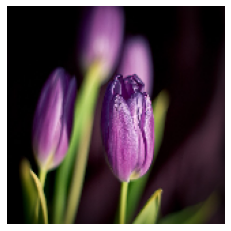

In [49]:
# img_dir_path = os.getenv("HOME") + "/aiffel"
# face_image_path = os.path.join(img_dir_path, '/flowers/flower_test.jpg')
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
# def show_and_predict_image(dirpath, filename, img_size=160):
#     filepath = os.path.join(dirpath, filename)
#     image = load_img(filepath, target_size=(img_size, img_size))
#     plt.imshow(image)
#     plt.axis('off')
#     image = img_to_array(image).reshape(1, img_size, img_size, 3)
#     prediction = model.predict(image)[0]
#     cat_percentage = round(prediction[0] * 100)
#     dog_percentage = round(prediction[1] * 100)
#     print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

# flower_image_path ='/aiffel'
# filename = "flower_test.jpg"
# show_and_predict_image(flower_image_path, filename)

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflower_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulips_percentage}% tulips, {sunflower_percentage}% sunflower")
    
filename = 'flower_test.jpg'
img_dir_path = '/aiffel/aiffel/flowers/'
show_and_predict_image(img_dir_path, filename)


## 회고
- k:처음부터 모델을 구현해서 테스트해보는것은 처음이었다. 지금까지 배운것들을 활용하여 프로젝트에서 원한 정확도를 처음으로 얻어보았다.
- p:처음에 모델의 구조와 정확도를올리기위해여러가지 방법들을 시도하면서 문제가 많고, 오류가 많이떠서 시간이 생각보다 오래걸렸다.테스트데이터대신 직접가져온 다른 flower이미지로 성능을 보려했는대 데이터의 경로문제로 자꾸 안되서 시간을 오래 잡아먹었다.. 결국 시도하지못했다.
- t:vgg16모델을 가져와서 학습시켰지만 resnet이나 다른google net같은 네트워크로 가져와서 학습시켜보고싶다.오류부분을 해결하여 다시 올려봐야겠다. (2번째 시도때 오류부분 해결, 경로설정완료)